<a href="https://colab.research.google.com/github/lasmit17/SpotifyProject/blob/master/XGBoost_Collab_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
#Packages, Libraries, Models...
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb 
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc, average_precision_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [3]:
#Reading CSVs
luke_df_2016 = pd.read_csv(f'Luke_2016_Top_Songs.csv')
luke_df_2017 = pd.read_csv(f'Luke_2017_Top_Songs.csv')
luke_df_2018 = pd.read_csv(f'Luke_2018_Top_Songs.csv')
luke_df_2019 = pd.read_csv(f'Luke_2019_Top_Songs.csv')
luke_df_2020 = pd.read_csv(f'Luke_2020_Top_Songs.csv')

jp_df_2017 = pd.read_csv(f'jp_2017_Top_Songs.csv')
jp_df_2018 = pd.read_csv(f"jp_2018_Top_Songs.csv")
jp_df_2019 = pd.read_csv(f"jp_2019_Top_Songs.csv")
jp_df_2020 = pd.read_csv(f"jp_2020_Top_Songs.csv")

fabian_df_2018 = pd.read_csv(f"FP_2018_Top_Songs.csv")
fabian_df_2019 = pd.read_csv(f"fp_2019_Top_Songs.csv")
fabian_df_2020 = pd.read_csv(f"FP_2020_Top_Songs.csv")
fabian_df_2017 = pd.read_csv(f"FP_2017_Top_Songs.csv")

In [4]:
#Release Year
#Creating a function to add a new variable to the dataframes, the song release year
def get_years(df):
    years = []
    for date in df['release_date'].values:
        if '-' in date:
            years.append(date.split('-')[0])
        else:
            years.append(date)
    df['release_year'] = years
    return df


#Adding release year to each dataframe for each individual
luke_df_2016 = get_years(luke_df_2016)
luke_df_2017 = get_years(luke_df_2017)
luke_df_2018 = get_years(luke_df_2018)
luke_df_2019 = get_years(luke_df_2019)
luke_df_2020 = get_years(luke_df_2020)

jp_df_2017 = get_years(jp_df_2017)
jp_df_2018 = get_years(jp_df_2018)
jp_df_2019 = get_years(jp_df_2019)
jp_df_2020 = get_years(jp_df_2020)

fabian_df_2018 = get_years(fabian_df_2018)
fabian_df_2019 = get_years(fabian_df_2019)
fabian_df_2020 = get_years(fabian_df_2020)
fabian_df_2017 = get_years(fabian_df_2017)

In [5]:
#Joining DataFrames
#combining each person's data
luke_df_concat = pd.concat([luke_df_2016, luke_df_2017, luke_df_2018, luke_df_2019, luke_df_2020], ignore_index=True, axis=0)
luke_df_concat['users_name'] = "Luke"

jp_df_concat = pd.concat([jp_df_2017, jp_df_2018, jp_df_2019, jp_df_2020], ignore_index=True, axis=0)
jp_df_concat['users_name'] = "JP"

fabian_df_concat = pd.concat([fabian_df_2017, fabian_df_2018, fabian_df_2019, fabian_df_2020], ignore_index=True, axis=0)
fabian_df_concat['users_name'] = "Fabian"

#Combining every data frame together into one
all_df = pd.concat([luke_df_concat, jp_df_concat, fabian_df_concat], ignore_index=True, axis=0)

all_df["release_year"] = pd.to_numeric(all_df["release_year"])

In [6]:
#Remove Repeats
# remove repeats on individual playlists
def remove_repeats(df):
    rows_old = range(len(df['name']))
    rows_new = []
    skips = []
    for i in range(len(df['name'])):
        for j in range(i+1, len(df['name'])):
            if (df['name'][i] == df['name'][j]) and (df['artist'][i] == df['artist'][j]):
                skips.append(j)
    for row in rows_old:
        if not row in skips:
            rows_new.append(row)
    df = df.iloc[rows_new,:].reset_index(drop=True)
    return df
remove_repeats(all_df)

,name,album,artist,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,...,loudness,speechiness,tempo,valence,time_signature,key,mode,uri,release_year,users_name
0,In the Bag,GO:OD AM,Mac Miller,2015-09-18,275506,52,0.3010,0.717,0.634,0.000000,...,-6.887,0.4090,143.812,0.564,4,1,1,spotify:track:7odIekt1GqLVEAAWdnd9mJ,2015,Luke
1,Gasoline,BADLANDS (Deluxe),Halsey,2015-08-28,199593,73,0.2230,0.731,0.580,0.000000,...,-7.328,0.0399,119.997,0.319,4,10,0,spotify:track:2IO7yf562c1zLzpanal1DT,2015,Luke
2,Closer,Closer,The Chainsmokers,2016-07-29,244960,85,0.4140,0.748,0.524,0.000000,...,-5.599,0.0338,95.010,0.661,4,8,1,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,2016,Luke
3,Morocco,Mountains Beaches Cities,Moon Taxi,2013-09-10,208080,0,0.0178,0.616,0.894,0.000103,...,-3.209,0.0508,115.077,0.542,4,1,0,spotify:track:30lgD1UuHczwlxa7NZFeSQ,2013,Luke
4,Temporary Love,Temporary Love,The Brinks,2015-12-04,205129,46,0.6560,0.714,0.555,0.000289,...,-7.550,0.0459,102.971,0.329,4,6,0,spotify:track:2U6hcDLZHYRSd9Up0mMe9W,2015,Luke
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1206,1975,1975,MAJAN,2019-05-10,223795,54,0.2340,0.635,0.473,0.000000,...,-10.137,0.0623,140.094,0.191,4,8,1,spotify:track:6mf2YhtRwQUdnORRrRQ3hP,2019,Fabian
1207,Whasgood?!,Whasgood?!,blackwave.,2018-06-08,221800,33,0.0311,0.851,0.669,0.000086,...,-4.259,0.0721,109.974,0.835,4,1,1,spotify:track:5vhwne4NXUgFdtbnTMz37m,2018,Fabian
1208,You Can't Hold Me Down,An Ordinary Day In An Unusual Place,Us3,2001-01-01,261466,44,0.0229,0.824,0.723,0.011100,...,-4.814,0.0305,116.013,0.963,4,1,1,spotify:track:366E1dYGmFM75DxX0yxlSq,2001,Fabian
1209,Satisfied 'N' Tickled Too,Satisfied 'N Tickled Too,Taj Mahal,1976-06-25,326826,43,0.7470,0.841,0.591,0.037100,...,-9.081,0.0527,134.796,0.817,4,3,1,spotify:track:4v6gpq8gNsvKekCc2rgXb5,1976,Fabian


In [8]:
#Scaling Variables 0<var<1
# Create function to do linear transformation on variable to change value to [0,1]
def convert_scale(df, col):
    df[col + '_old'] = df[col]
    new_max = 1
    new_min = 0
    new_range = new_max-new_min
    max_val = df[col].max()
    min_val=df[col].min()
    val_range = max_val - min_val
    df[col]=df[col].apply(lambda x: (((x-min_val)*new_range)/val_range)+new_min)
    return



#Setting the numerical spotify features
numeric_spotify_features = ['energy',
    'valence',
    'danceability',
    'liveness',
    'speechiness',
    'instrumentalness',
    'acousticness',
    'loudness',
    'length',
    'popularity',
    'tempo',
    'release_year']


for col in numeric_spotify_features:
    convert_scale(all_df, col)

In [9]:
#HotEncoding Variables
#Now we need to address the categorical variables. First, we will utilize One Hot Encoder
ohe = OneHotEncoder()
ohe_results = ohe.fit_transform(all_df[['time_signature', 'mode', 'key']])
onehot_df = pd.DataFrame(ohe_results.toarray(), columns=['time_signature_1', 'time_signature_2',
                                                     'time_signature_3', 'time_signature_4',
                                                     'mode_1', 'mode_2',
                                                     'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6',
                                                     'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'key_12'])
all_df = pd.concat([all_df, onehot_df], axis=1)

In [10]:
#Combine all Features
#Finally, we combine all of our features used for prediction into one list
all_spotify_features = ['energy',
    'valence',
    'danceability',
    'liveness',
    'speechiness',
    'instrumentalness',
    'acousticness',
    'loudness',
    'length',
    'popularity',
    'tempo',
    'release_year',
    'time_signature_1',
    'time_signature_2',
    'time_signature_3',
    'time_signature_4',
    'mode_1',
    'mode_2',
    'key_1',
    'key_2',
    'key_3',
    'key_4',
    'key_5',
    'key_6',
    'key_7',
    'key_8',
    'key_9',
    'key_10',
    'key_11',
    'key_12']


PREP FINISHED











MODELS BEGIN

In [11]:
#Set X,Y, Split Train/Test
#Now, we can finally set our X and y values. X will be all the Spotify features provided above and y will be each individual's name
X = all_df[all_spotify_features]
y = all_df['users_name']

#Here we split our data up into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)



LOGISTIC REGRESSION

In [17]:
#Pipeline, Fitting, Predicting
#Setting up a pipeline that scales and then utilizes multinomial logistic regression
pipe = Pipeline([('scaler', StandardScaler()),     # Step 1
                 ('model', LogisticRegression(multi_class='multinomial', solver='lbfgs')) # Step 2
                 ])
#Fitting and predicting with our data
pipe.fit(X_train, y_train)
pred_logi = pipe.predict(X_test)

#print("Accuracy:",metrics.accuracy_score(y_test, pred_logi))

In [20]:
#Cross-validation
cv = KFold(n_splits=10, random_state=123, shuffle=True)
scores = cross_val_score(pipe, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
scores


array([0.67346939, 0.62244898, 0.59183673, 0.67346939, 0.59183673,
       0.6185567 , 0.59793814, 0.58762887, 0.58762887, 0.53608247])

XGBOOST

In [21]:
#XGBoost

#Setting Luke to 2, JP to 1, and Fabian to 0 in order to utilize XGBoost
#This is our base model for XGBoost
all_df["users_name"] = all_df['users_name'].replace({"Luke":2,"JP":1,"Fabian":0})

X = all_df[all_spotify_features]
y = all_df['users_name']
data_dmatrix = xgb.DMatrix(data=X,label=y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

xg_reg = xgb.XGBClassifier(objective ='multi:softmax', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10, num_classes = 3)
xg_reg.fit(X_train,y_train)
all_df.users_name
pred_xgb = xg_reg.predict(X_test)

In [28]:
#XGBoost parameters
mse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))
print("MSE: %f" % (mse_xgb))

xgb_initial_score = cross_val_score(xg_reg, X, y, cv=10)
xgb_initial_score

xgb_initial_accuracy = accuracy_score(y_test, pred_xgb)
xgb_initial_accuracy

#Hyperparameter Tuning Section to improve performance of the XGBoost model

#Setting the parameters to test
params = {
    "objective"         :"multi:softmax",
    'colsample_bytree'  : [0.3, 0.4, 0.5, 0.7],
    'learning_rate'     : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    'max_depth'         : [3, 4, 5, 6, 8, 10, 12, 15],
    'alpha'             : [2, 4, 8, 10, 15, 20],
    'gamma'             : [0.0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight'  : [1, 3, 5, 7],
}

xgb_classifier = xgb.XGBClassifier()
random_search = RandomizedSearchCV(xgb_classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)

random_search.fit(X,y)

#Checking to see what the best estimator and parameters are for our model based on the randomized search performed above
random_search.best_estimator_
random_search.best_params_


final_xgb_classifier = xgb.XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3,
              enable_categorical=False, gamma=0.2, gpu_id=0,
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=12,
              min_child_weight=7, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=10, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

MSE: 0.938083
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  category=UserWarning,


In [29]:
#Utilizing cross validation to evaluate the performance of the model
xgb_final_score = cross_val_score(final_xgb_classifier, X, y, cv=10)
#Comparing the two arrays from before and after hyperparameter tuning
xgb_initial_score
xgb_final_score

#Fitting our final XGB model on our training data
final_xgb_classifier.fit(X_train,y_train)

pred_xgb_final = final_xgb_classifier.predict(X_test)

mse_xgb_final = np.sqrt(mean_squared_error(y_test, pred_xgb_final))
print("MSE: %f" % (mse_xgb_final))

xgb_final_accuracy = accuracy_score(y_test, pred_xgb_final)
xgb_final_accuracy

#After hyperparameter tuning, our MSE decreased from 0.9029 to 0.8575


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py", line 732, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/training.py", line 216, in train
    xgb_model=xgb_model, callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/training.py", line 

XGBoostError: ignored

RANDOM FOREST

In [30]:
#Now we'll work to build a Random Forest model. This will serve as our base Random Forest model
from sklearn.ensemble import RandomForestClassifier

#Bringing in the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets created earlier on
clf.fit(X_train,y_train)

clf_y_pred = clf.predict(X_test)



In [34]:
#Checking to see which parameters are being utilized by Random Forest
clf.get_params()

n_estimators = [5,20,50,100]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)]
min_samples_split = [2, 6, 10]
min_samples_leaf = [1, 3, 4]
bootstrap = [True, False]

clf_params = {
    'n_estimators'      : n_estimators,
    'max_features'      : max_features,
    'max_depth'         : max_depth,
    'min_samples_split' : min_samples_split,
    'min_samples_leaf'  : min_samples_leaf,
    'bootstrap'          : bootstrap
}

clf_random = RandomizedSearchCV(estimator = clf,param_distributions = clf_params,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

clf_random.fit(X_train, y_train)

#Now lets see what the best parameters are in this case
clf_random.best_params_

{'n_estimators': 50,
 'min_samples_split': 10,
 'min_samples_leaf': 3,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': False}

#Creating a RF model with the best parameters
clf_final = RandomForestClassifier(n_estimators = 50,
 min_samples_split = 10,
 min_samples_leaf = 3,
 max_features = 'auto',
 max_depth = 90,
 bootstrap = False)

#Fitting the new model to the training data
clf_final.fit(X_train,y_train)
clf_pred_final = clf_final.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, clf_pred_final))

clf_final_score = cross_val_score(clf_final, X, y, cv=10)
clf_initial_score
clf_final_score



Fitting 5 folds for each of 100 candidates, totalling 500 fits
Accuracy: 0.6738461538461539


array([0.63846154, 0.6       , 0.71538462, 0.70769231, 0.66923077,
       0.63076923, 0.71538462, 0.76153846, 0.64615385, 0.66153846])

METRICS

In [35]:
#jp's additions:


from sklearn.metrics import f1_score

#F1 score is always between 0 and 1
#Score of 0 is bad, score of 1 is good

f1_logi = f1_score(y_test, pred_logi, average='macro')
f1_xgb = f1_score(y_test, pred_xgb, average='macro')
print("F1 Logistic (base):",f1_logi)
print("F1 Logistic (xgb):",f1_xgb)


f1_rf_macro = f1_score(y_test, clf_y_pred, average='macro')
f1_rf_micro = f1_score(y_test, clf_y_pred, average='micro')
f1_rf_w = f1_score(y_test, clf_y_pred, average='weighted')

print("\nF1 RandomForest (base_macro):",f1_rf_macro)
print("F1 RandomForest (base_micro):",f1_rf_micro)
print("F1 RandomForest (base_weighted):",f1_rf_w)


print("\n  The difference between macro, micro, and weighted is this:")
print("  basically, since we have a 3x3 confusion matrix, we don't only have")
print("  ONE kind of false positive, true positive, etc...")
print("  the model can predict a true jp as being luke OR fabio, meaning our TN, TP, FN, FP")
print("  are not so straightforward")
print("\n  --macro, micro, and weighted are just different ways of combining the 3x3 matrix")
print("  to get a better picture of your f1 score")

f1_rf_tuned_macro = f1_score(y_test, clf_pred_final, average='macro')
f1_rf_tuned_micro = f1_score(y_test, clf_pred_final, average='micro')
f1_rf_tuned_w = f1_score(y_test, clf_pred_final, average='weighted')

print("\nF1 RandomForest (tuned_macro):",f1_rf_tuned_macro)
print("F1 RandomForest (tuned_micro):",f1_rf_tuned_micro)
print("F1 RandomForest (tuned_weighted):",f1_rf_tuned_w)

ValueError: ignored

In [ ]:
#MCC is Matthews Correlation Coefficient
#MCC score is always between -1 and 1
#Score of -1 is bad, score of 0 would be an average random prediction, score of 1 is perfect model

mcc_logi = matthews_corrcoef(y_test, pred_logi)
mcc_xgb = matthews_corrcoef(y_test, pred_xgb)
mcc_rf = matthews_corrcoef(y_test, clf_y_pred)
mcc_rf_tuned = matthews_corrcoef(y_test, clf_pred_final)

print("MCC Logistic (base):",mcc_logi)
print("MCC Logistic (xgb):","again, python says 'no module named xgboost' when i import xgboost")
print("\nMCC RandomForest (base):",mcc_rf)
print("\nMCC RandomForest (tuned):",mcc_rf_tuned)



#looks like our best model truly is the base random forest
pred_xgb

In [33]:
#Logistic/ Cross Validate Metrics
#More metrics
accuracy = accuracy_score(y_test, pred_logi)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, pred_logi))

print(matthews_corrcoef(y_test, pred_logi))





#Evaluating the base Random Forest Model


clf_initial_score = cross_val_score(clf, X, y, cv=10)
clf_initial_score

#Our base RF model has an accuracy of about 69.5%

Accuracy: 0.00


ValueError: ignored

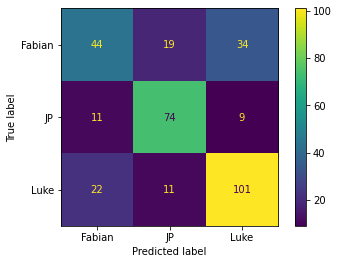

In [40]:
#Confusion for Random Forest (base model)
confusion_matrix_RF = metrics.confusion_matrix(y_test, clf_y_pred)

cm_display_RF = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_RF, 
                                                display_labels = ["Fabian", "JP", "Luke"])

cm_display_RFT.plot()
plt.show()